# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Predicting Hospital Readmission Rates for Diabetes
## CS109a: Introduction to Data Science



**Harvard University**<br/>
**Fall 2023**<br/>
**Team members**: Karim Gowani, Ryan McGillicuddy, Yaseen Mohmand, Steven Worthington


<hr style="height:2pt">

# Introduction

## i. About This Notebook

This notebook represents a summary of a series of exploratory analysis, wherein we attempt various approaches to classify X-ray images into 14 disease classes and a 'no finding' class. For an overview of the analytical sections of this notebook, please see the [Notebook Contents](#Notebook-Contents) index listed below this Introduction.

### i.i. A note about supporting notebooks

The code and results reported in this notebook are only a summary of the work completed for this project - they represent the final form of our analyses. Supplemental notebooks containing auxillary EDA, data cleaning, and model exploration illustrated in this report can be found in the **`notebooks/`** directory of the **[GitHub project repository](https://github.com/liujinjie111/chestXray)**. The notebooks in this repository are not designed to be run in any particular order to reproduce the results shown in the final report. They just show the extra work and experiments we have tried that are not shown in the final report.

## ii. Research Question

After initial exploration and cleaning of the data, we have focused our efforts on the following research question:

Which model architecture performs best for out-of-sample classification of the X-ray images into the 14 disease classes and 'no finding' class?

## iii. Summary of Findings

We found this project to be both interesting and quite challenging. We created an analysis pipeline using TF datasets that was efficient enough for us to experiment with many different modeling architectures in a short period of time. This encorporated downsampling of the majority image label classes to make modeling more tractable. We incorporated data augmentation steps into the model itself to use GPU, rather than CPU, cycles, thus reducing the computational burden and time cost of preprocessing, allowing us to devote more time to exploring different modelling approaches. 


<a name="Notebook-Contents"></a>
# Notebook Contents

[Introduction](#Introduction)

[Setup](#Setup)

**[1. Data Source and Composition](#1.-Data-Source-and-Composition)**

- [1.1. Data Source and Substantive Context](#1.1.-Data-Source-and-Substantive-Context)

- [1.2. Data Granularity](#1.2.-Data-Granularity)

- [1.3. Class Imbalance](#1.3.-Class-Imbalance)
 
- [1.4. Missing Observations](#1.4.-Missing-Observations)
  
**[2. Exploratory Data Analysis and Preprocessing](#2.-Exploratory-Data-Analysis-and-Preprocessing)**

- [2.1. Exploratory Data Analysis of Raw Data](#2.1.-Exploratory-Data-Analysis-of-Raw-Data)

- [2.2. Data Preprocessing](#2.2.-Data-Preprocessing)

- [2.3. Data Partitioning](#2.3.-Data-Partitioning)
 
- [2.4. Exploratory Data Analysis of Cleaned Data](#2.4.-Exploratory-Data-Analysis-of-Cleaned-Data)

- [2.5. Summary of EDA Key Findings](#2.5.-Summary-of-EDA-Key-Findings)

**[3. Research Questions](#3.-Research-Questions)**

**[4. Modeling Pipeline and Training](#4.-Modeling-Pipeline-and-Training)**

- [4.1. Candidate Models](#4.1.-Candidate-Models)

- [4.2. Model Performance Assessment](#4.2.-Model-Performance-Assessment)

- [4.3. Feature Engineering](#4.3.-Feature-Engineering)

- [4.4. Base Model](#4.4.-Base-Model)

- [4.5. Model Training](#4.5.-Model-Training)

**[5. Model Selection and Evaluation](#5.-Model-Selection-and-Evaluation)**

- [5.1. Model Selection](#5.1.-Model-Selection)

- [5.2. Best Model Performance](#5.2.-Best-Model-Performance)

- [5.3. Variable Importance](#5.3.-Variable-Importance)

**[6. Conclusions](#6.-Conclusions)**

- [6.1. Patient Early Readmittance Rate](#6.1.-Patient-Early-Readmittance-Rate)

- [6.2. Patient Risk Profiles](#6.2.-Patient-Risk-Profiles)

**[7. Future Work](#7.-Future-Work)**

**[8. References](#8.-References)**

# Setup

[Return to top](#Notebook-Contents)

The following sections include general setup code for:
1. Installing the necessary packages needed for data preparation, modeling, and visualization
2. Setting pseudo-random number seeds for reproducibility

### Install Modules

In [15]:
# basic modules
import os
import time
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# metrics & utilities 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample

# warnings
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-notebook')
sns.set_style('darkgrid')

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# user defined functions
from utility_functions import get_performance_metrics, get_results_df, plot_performance_metrics
from utility_functions import plot_ROC_curves, plot_PR_curves

### Set RNG seeds

In [ ]:
# Ensure replicable results
import os
import random as rn
SEED = 109
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(SEED)
np.random.seed(SEED)
rn.seed(SEED)

<a name="1.-Data-Source-and-Composition"></a>
# 1. Data Source and Composition

[Return to top](#Notebook-Contents)

<a name="1.1.-Data-Source-and-Substantive-Context"></a>
## 1.1 Data Source and Substantive Context

[Return to top](#Notebook-Contents)

Our dataset is from the UC Irvine ML Repository and involves patient records of those diagnosed with diabetes from 1999 through 2008 at 130 US hospitals. We have downloaded this dataset and examined it. It has ~102K records, a binary target variable, and 47 features, the majority of which are categorical.

<a name="1.2.-Data-Granularity"></a>
## 1.2 Data Granularity

[Return to top](#Notebook-Contents)

In a clinical setting, doctors and medical staff would like to answer the question, “given information from the current and previous hospitalizations, how likely is it for this patient to be readmitted to hospital early (within 30 days)?”. This question is inherently at the patient-level, but each record in the dataset is at the level of an ‘encounter’, which represents a patient hospitalization event (rather than an outpatient visit). A subset of 16.5% of patients have multiple encounters.

A patient-level perspective is more likely to be of benefit to clinicians, since answering the above question will help medical personnel prioritize follow-ups and interventions through the creation of patient risk profiles, which can identify patients at the highest risk level for early hospital readmittance. This information is actionable and can be used to mitigate negative health outcomes for these patients as well as increased costs for the hospital and insurance carrier. We will therefore aggregate data from the encounter-level to the patient-level.

For those patients with multiple encounters, however, features that vary at the encounter-level contain important information that we do not wish to discard. For example, if a patient was readmitted early relative to the immediately preceding encounter, it is perhaps more likely that the patient will be readmitted to hospital early again after the current encounter. Therefore, our strategy will be to select only the final encounter for these patients and create several new derived features that encapsulate the history of their previous encounters. Such features will include, but are not limited to, the number of previous inpatient encounters, whether the last encounter resulted in early readmission, and whether the patient ever had a high value of A1c.

In following this approach, we will have to make a (reasonable) assumption that encounters for each patient are in temporal order in the dataset because no explicit date information is provided.

<a name="1.3.-Class-Imbalance"></a>
## 1.3 Class Imbalance

[Return to top](#Notebook-Contents)

About 11% of encounters belong to the positive class (readmitted within 30 days), so while there is imbalance, it is not severe. While our performance metric of interest - AUC - is robust to class imbalance, we will still try to address this issue in several ways. We will use stratified sampling in train/test splits, and we will attempt the standard techniques of undersampling and oversampling, as well as use of class weights built into the different ML models of interest, including Logistic Regression, CART, Random Forest, and XG Boost.

<a name="1.4.-Missing-Observations"></a>
## 1.4 Missing Observations

[Return to top](#Notebook-Contents)

There are only 7 (out of 47) relevant columns that contain missing values:
- weight is missing ~97% of its values, so this column can be safely dropped; no other numerical column has missing values.
- medical specialty is missing ~49% of its values, but may be relevant to the classification task, so we keep it and fill the missing values with ‘unknown’..
- payer code (insurance carrier) is missing ~40% of the values, but because it does not seem to be relevant to the target - it is also a candidate for being eliminated altogether.

The remaining columns have less than 3% values missing so they can be managed. They are all categorical, including race and diagnosis codes. As is common for categorical variables, we will fill the missing values with 'unknown'.

<a name="2.-Exploratory-Data-Analysis-and-Preprocessing"></a>
# 2. Exploratory Data Analysis and Preprocessing

[Return to top](#Notebook-Contents)

In this section, we load our raw data, perform some initial exploratory data analysis to assess what pre-processing steps are necessary, perform those preprocessing steps, partition the data into training and testing sets, perform additional exploratory data analysis on the cleaned data, and present a summary of our findings.

<a name="2.1.-Exploratory-Data-Analysis-of-Raw-Data"></a>
## 2.1 Exploratory Data Analysis of Raw Data

[Return to top](#Notebook-Contents)

### Raw Diabetes Data

In [16]:
# load the encounter-level data
df_encounters = pd.read_csv('../data/diabetic_data.csv', 
                            na_values='?',
                            low_memory=False # silence the mixed dtypes warning
                           )
df_encounters.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Data types

In [17]:
# dtypes and columns counts
data_types= df_encounters.dtypes
type_counts = data_types.value_counts()
print(type_counts)

object    37
int64     13
Name: count, dtype: int64


In [18]:
# dtype for each column
data_types

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

### Summary Statistics

In [19]:
# summary stats (after removing ID columns)
df_summary = df_encounters[[col for col in df_encounters.columns if not (col.endswith('_id') or col.endswith('_nbr'))]]
df_summary.describe().round(1)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0,101766.0
mean,4.4,43.1,1.3,16.0,0.4,0.2,0.6,7.4
std,3.0,19.7,1.7,8.1,1.3,0.9,1.3,1.9
min,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
25%,2.0,31.0,0.0,10.0,0.0,0.0,0.0,6.0
50%,4.0,44.0,1.0,15.0,0.0,0.0,0.0,8.0
75%,6.0,57.0,2.0,20.0,0.0,0.0,1.0,9.0
max,14.0,132.0,6.0,81.0,42.0,76.0,21.0,16.0


### Missing data

We can see that some of the columns have a lot of missing data such as Weight, Max_glu_serum, A1C result. We will be treating these columns in the subsequent cells.

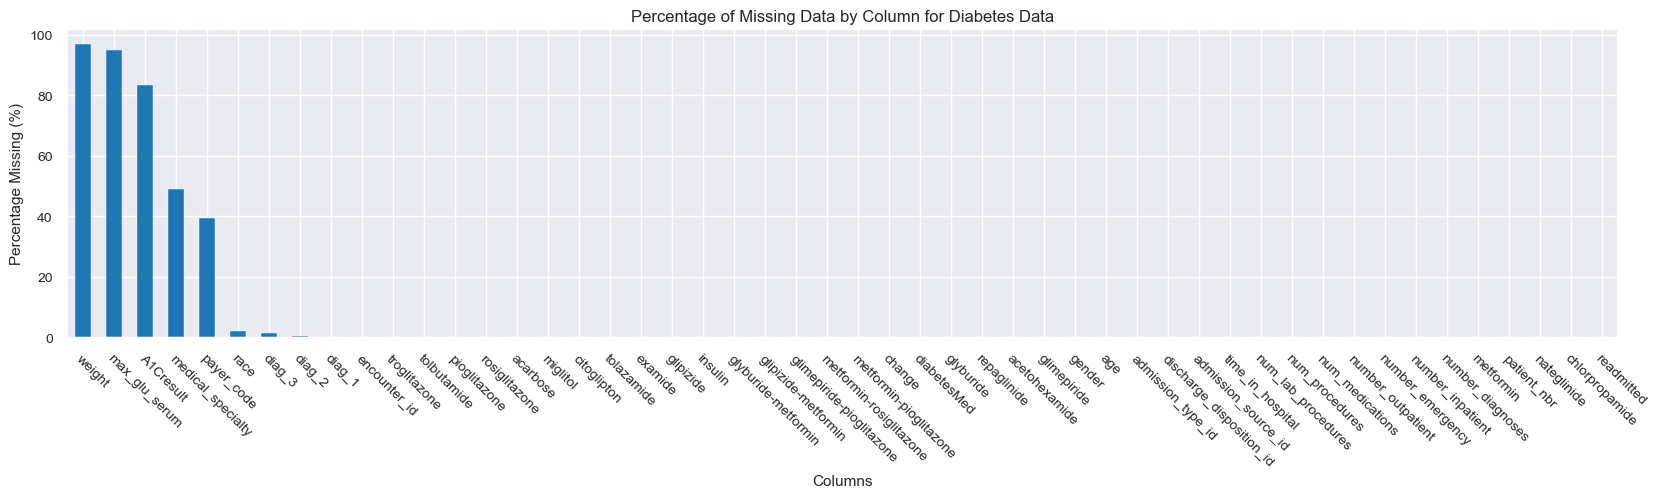

In [24]:
# Calculate missing data percentages
missing_data_percentage = (df_encounters.isnull().sum() / len(df_encounters)) * 100
# Sort the values for better visualization
missing_data_percentage = missing_data_percentage.sort_values(ascending=False)

# Create a figure with specified size
plt.figure(figsize=(20, 4))
# Plot the data as a vertical bar plot
missing_data_percentage.plot(kind='bar')
plt.title('Percentage of Missing Data by Column for Diabetes Data')
plt.xticks(rotation=-45, ha="left", rotation_mode="anchor") 
plt.ylabel('Percentage Missing (%)')
plt.xlabel('Columns');

In [25]:
# missing values table
missing_values = df_encounters.isnull().sum()
missing_percentage = (100 * df_encounters.isnull().sum() / len(df_encounters))
missing_values_table = pd.concat([missing_values, missing_percentage], axis=1)
    
missing_values_table = missing_values_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
missing_values_table = missing_values_table[
    missing_values_table.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
print(f"The diabetes data have " + str(df_encounters.shape[1]) + " columns.\n"      
    "There are " + str(missing_values_table.shape[0]) +
    " columns that have missing values.\n")

display(missing_values_table)

The diabetes data have 50 columns.
There are 9 columns that have missing values.



,Missing Values,% of Total Values
weight,98569,96.9
max_glu_serum,96420,94.7
A1Cresult,84748,83.3
medical_specialty,49949,49.1
payer_code,40256,39.6
race,2273,2.2
diag_3,1423,1.4
diag_2,358,0.4
diag_1,21,0.0


### Numeric Data

**Distribution plots:**

1. Most of our other variable distribution is skewed either to the right or left, which is expected because for example we would not expect a lot of patients to have multiple emergency visits, we would expect the majority to have 0 emergencies and then a long tail.

2. Some of the numeric variables we see more variablility than others. The variables with more variablility might have more predictive power.

3. We can also see that different variables have very different scales, which will make it important for us to scale the normalize/ transform the data if we want to use predictive techniques like k-NN.


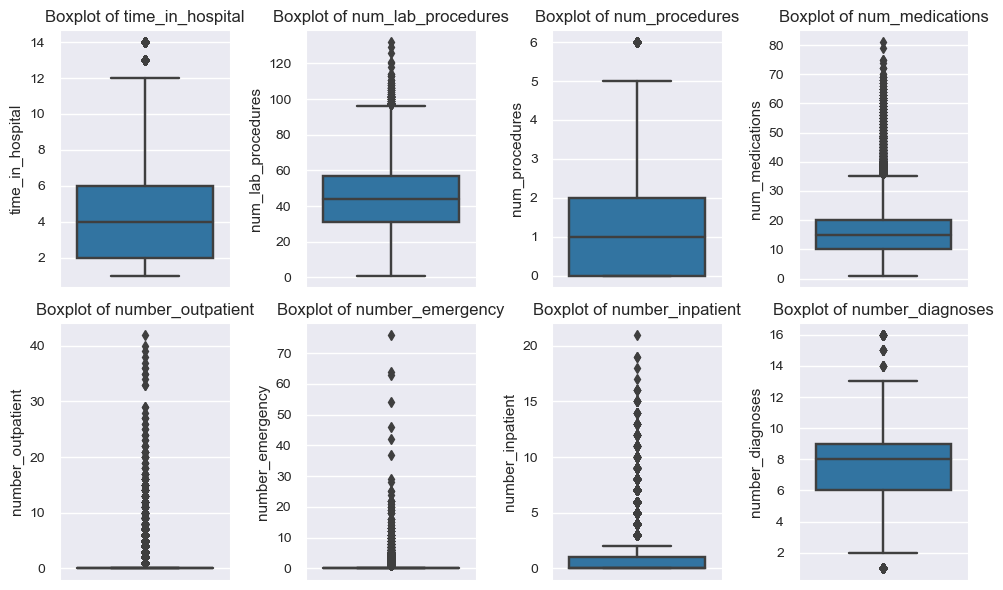

In [29]:
# boxplots for each numeric column
box_vars = ['time_in_hospital', 'num_lab_procedures', 
            'num_procedures', 'num_medications', 'number_outpatient',
            'number_emergency', 'number_inpatient', 'number_diagnoses']

fig, axes = plt.subplots(2, 4, figsize=(10, 6))
for ax, column in zip(axes.flatten(), box_vars):
    sns.boxplot(y=column, data=df_encounters, ax=ax)
    ax.set_title(f'Boxplot of {column}')
plt.tight_layout();

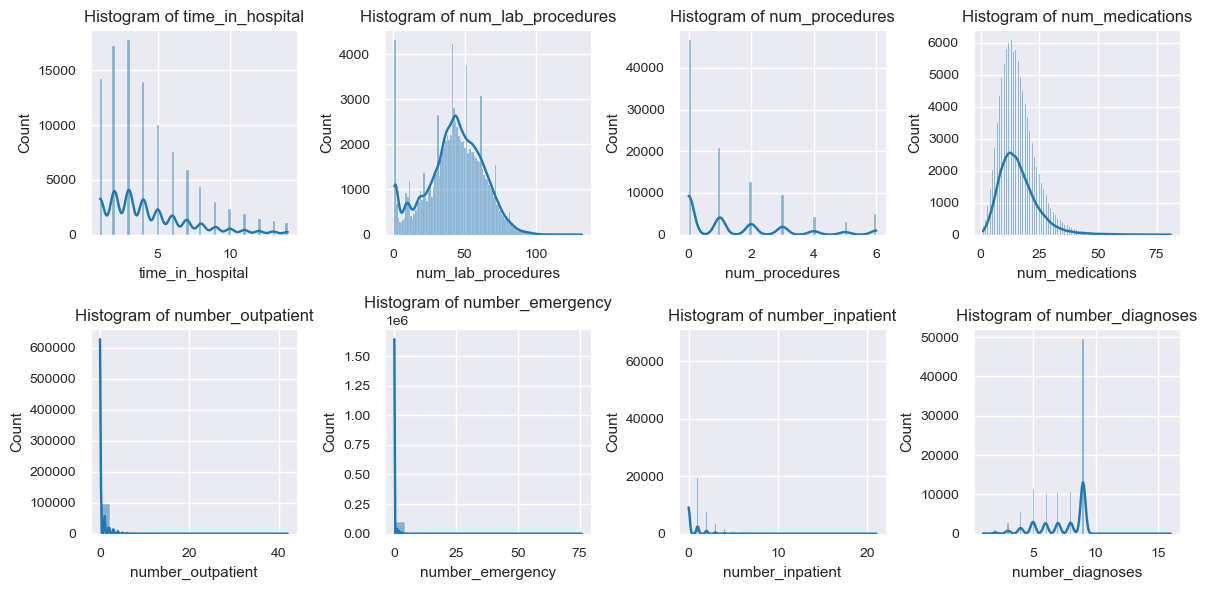

In [31]:
box_vars = ['time_in_hospital', 'num_lab_procedures', 
            'num_procedures', 'num_medications', 'number_outpatient',
            'number_emergency', 'number_inpatient', 'number_diagnoses']

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, column in zip(axes.flatten(), box_vars):
    sns.histplot(df_encounters[column], kde=True, ax=ax)  # using seaborn's histplot
    ax.set_title(f'Histogram of {column}')
plt.tight_layout();

**Corelation Plots:**

Our correlation analysis reveals moderate associations among several variables within the dataset. Notably, no pair of variables exhibits an extremely high correlation exceeding the 90% threshold.

Key observations of notable correlations include:

1. A predictable inverse relationship between 'gender_male' and 'gender_female,' as they represent binary and mutually exclusive categories.
2. A discernible correlation between 'race_African American' and 'race_Caucasian,' which likely arises from the demographic representation in the dataset, where Caucasians form the majority and African Americans are the second-largest demographic group.
3. There is an observable correlation between the 'not_readmitted' and 'readmitted_within_30_days' categories. This pattern is attributable to the predominance of the 'not_readmitted' group contrasted with the sizable proportion of cases readmitted within a 30-day period.

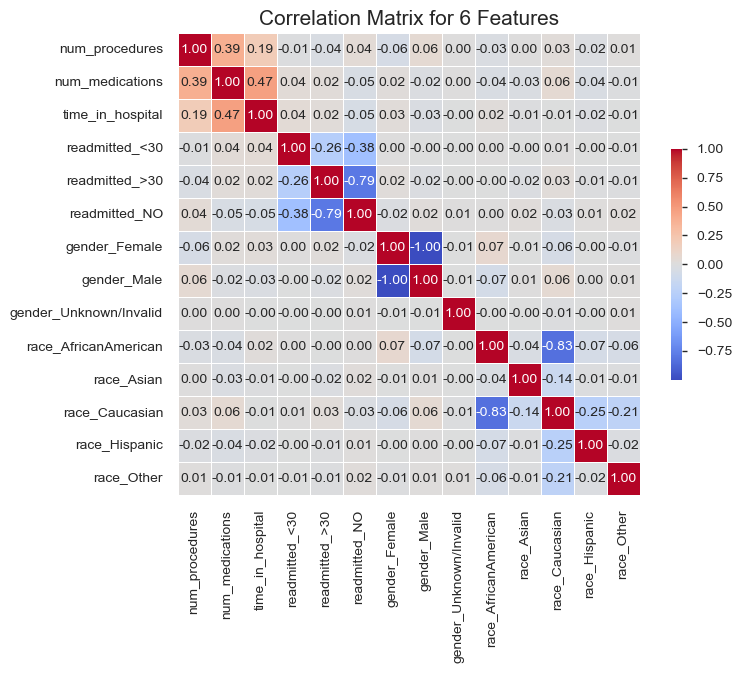

In [33]:
# correlation visualization
cor_vars = ['readmitted', 'gender', 'race', 'num_procedures', 
            'num_medications', 'time_in_hospital']
corr = pd.get_dummies(df_encounters[cor_vars]).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix for 6 Features', fontsize=15);

### Class Imbalance

Our analysis indicates that the target variable, 'readmission within 30 days,' is underrepresented, comprising just 11.15% of the cases, thus confirming a class imbalance in the dataset. This imbalance is a critical factor to consider as it can influence model training and the interpretability of performance metrics.

During the data preparation phase, particularly for train-test splitting, it is essential to maintain a stratified sampling approach. This will ensure that both the training and testing sets reflect the original proportion of the 30-day readmission cases.

In terms of model evaluation, reliance on accuracy as the sole performance metric may be inadequate and potentially misleading due to the skewed class distribution. Alternative metrics such as precision, recall, the F1 score, and the area under the Receiver Operating Characteristic (ROC) curve will be more informative. These metrics can provide a more nuanced view of the model's ability to correctly predict the minority class while distinguishing it from the majority class.

In [34]:
round(df_encounters['readmitted'].value_counts()/(len(df_encounters['readmitted']))*100, 4)

readmitted
NO     53.912
>30    34.928
<30    11.160
Name: count, dtype: float64

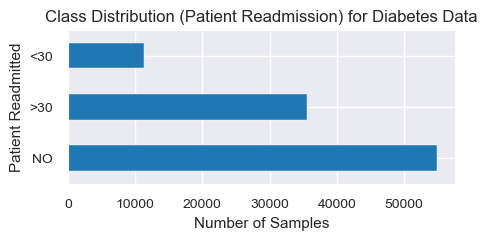

In [35]:
# visualize class imbalance
plt.figure(figsize=(5, 2))
df_encounters['readmitted'].value_counts().plot(kind='barh')
plt.title('Class Distribution (Patient Readmission) for Diabetes Data')
plt.ylabel('Patient Readmitted')
plt.xlabel('Number of Samples');

### Frequency of patient visits

The total number of patients with multiple encounters is 16773. this is 16.48 percent of the data. Majority of the patients only visited the hospital once.

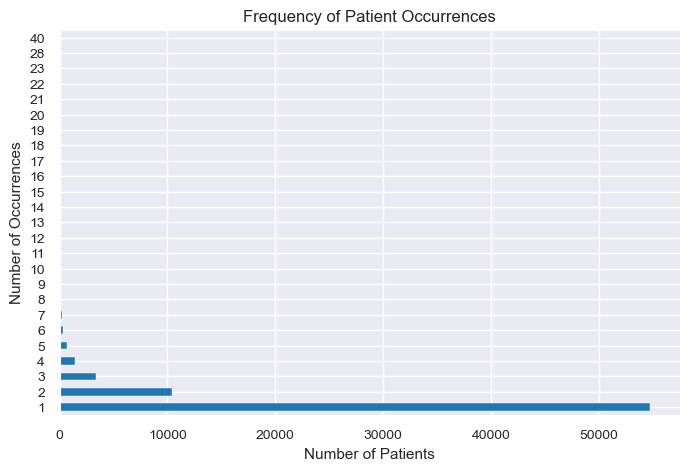

In [36]:
# calculate the frequency of each 'patient_id'
id_counts = df_encounters['patient_nbr'].value_counts()
# count how many 'patient_id's occur for each frequency
frequency_counts = id_counts.value_counts().sort_index()

plt.figure(figsize=(8,5))
frequency_counts.plot(kind='barh')
plt.ylabel('Number of Occurrences')
plt.xlabel('Number of Patients')
plt.title('Frequency of Patient Occurrences');

In [37]:
# group by 'patient_id' and filter out those with only one encounter
multiple_encounters = df_encounters.groupby('patient_nbr').filter(lambda x: len(x) > 1)
print(f"Total number of patients with multple encounters: {multiple_encounters['patient_nbr'].nunique()}")

Total number of patients with multple encounters: 16773


Total number of patients with different outcomes across encounters: 2766



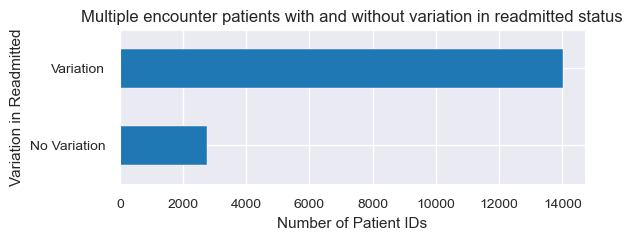

In [38]:
# check if 'readmitted' values vary within each group
def check_variation(df):
    return df['readmitted'].nunique() > 1

variation = multiple_encounters.groupby('patient_nbr').apply(check_variation)

variation_counts = variation.astype(int).value_counts().sort_index()

print(f"Total number of patients with different outcomes across encounters: {variation.value_counts()[1]}\n")

plt.figure(figsize=(6,2))
variation_counts.plot(kind='barh')
plt.xlabel('Number of Patient IDs')
plt.ylabel('Variation in Readmitted')
plt.title('Multiple encounter patients with and without variation in readmitted status')
plt.yticks(ticks=[0, 1], labels=['No Variation', 'Variation']);

In [40]:
variation = multiple_encounters.groupby('patient_nbr')  #.apply(check_variation)
display(variation)

### Categorical Data

**Age Distrubution**

The patient age distribution within our dataset skews older, with the majority of patients being over 50 years of age. Age categories under 50 are noticeably less populated, suggesting sparsity in younger demographics.

To streamline our analysis and potentially enhance model performance, we could consider aggregating these sparser younger age groups into a single category during preprocessing. This consolidation could reduce dimensionality and simplify patterns within the data, making it more manageable for subsequent analysis.

In [41]:
# age
df_encounters['age'].value_counts(normalize=True, dropna=False) * 100

age
[70-80)     25.616
[60-70)     22.093
[50-60)     16.957
[80-90)     16.899
[40-50)      9.517
[30-40)      3.709
[90-100)     2.745
[20-30)      1.628
[10-20)      0.679
[0-10)       0.158
Name: proportion, dtype: float64

**Gender Distrubution**

Both genders are equally represented in the dataset with slightly more females than males

In [42]:
# gender
df_encounters['gender'].value_counts(normalize=True, dropna=False) * 100

gender
Female             53.759
Male               46.238
Unknown/Invalid     0.003
Name: proportion, dtype: float64

**Race Distribution**

Our dataset's demographic breakdown is predominantly Caucasian, followed by African American as the second-largest racial group. This distribution aligns with the correlations observed earlier, reflecting the demographic representation within the data.

In [43]:
# race
df_encounters['race'].value_counts(normalize=True, dropna=False) * 100

race
Caucasian          74.778
AfricanAmerican    18.877
NaN                 2.234
Hispanic            2.002
Other               1.480
Asian               0.630
Name: proportion, dtype: float64

**Medical Specialty**

Nearly half of the 'medical_specialty' data is missing, yet its relevance for readmission insights means it's worth keeping. Internal Medicine is the predominant specialty, which is typical as it's often a first step before patients move to sub-specialties. Emergency/Trauma and Family/General Practice are also common, reflecting standard hospital intake patterns. Sub-specialties, while less frequent, could be critical in predicting 30-day readmissions and should not be overlooked in predictive modeling.

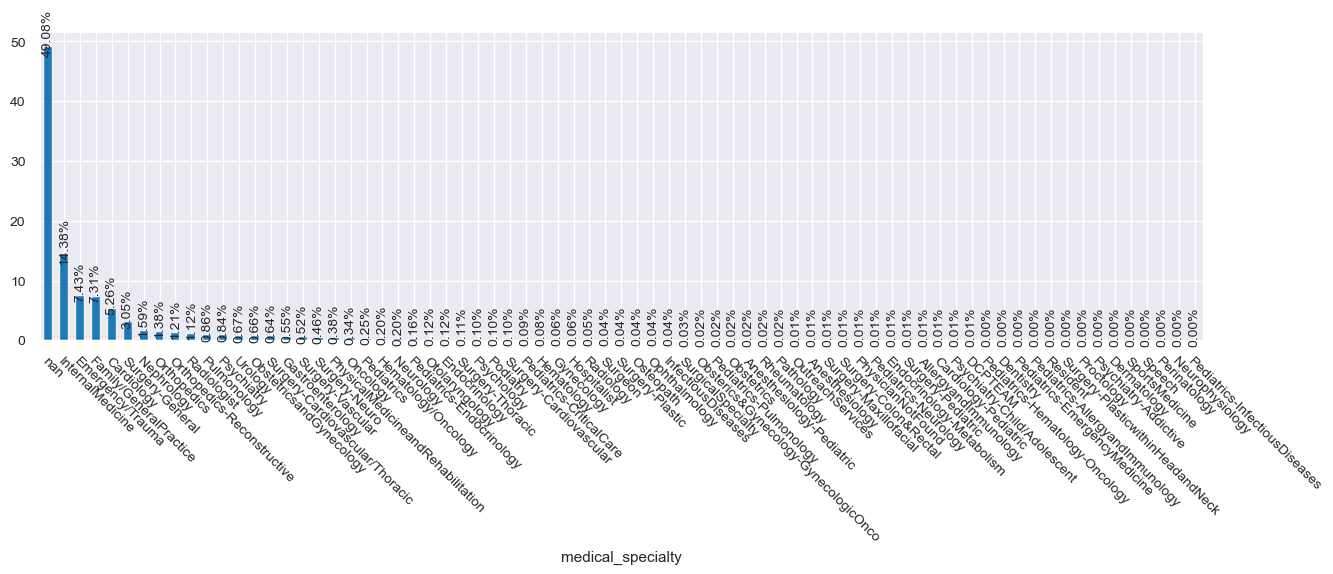

In [49]:
plt.figure(figsize=(15, 4))  # Set the figure size to make sure there's enough room for annotations

medical_speciality = df_encounters['medical_specialty'].value_counts(normalize=True, dropna=False) * 100
ax = medical_speciality.plot(kind='bar')  # Save the Axes object returned by the plot

# Annotate each bar with the percentage
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', rotation=90)
plt.xticks(rotation=-45, ha="left", rotation_mode="anchor");

<a name="2.2.-Data-Preprocessing"></a>
## 2.2 Data Preprocessing

[Return to top](#Notebook-Contents)

### Overall Strategy

Several of the categorical variables have many categories each that should be easily collapsed to reduce dimensionality:
- At the most extreme, the first diagnosis column has 716 codes, only 23 of which represent more than 1% of the observations; similarly for the second and third diagnosis variables. In fact, these diagnosis codes should be grouped into types such as Circulatory (codes 390-459), respiratory (codes 460-519), digestive (520-579), etc.
- Admission type code has 8 categories, 3 of which make up less than 1% of observations and can be safely collapsed.
- Medical specialty has 72 categories, but only 9 represent more than 1% of the observations.
- Age buckets can be consolidated: Currently, each bucket includes only 10 years. Less than 1% of
the observations fall into age < 20 and age > 90, for instance.

Furthermore, patients who were discharged with codes such as expired, hospice, transferred to another institution as inpatient, etc. should be filtered out as these types of discharge codes are of no practical relevance for predicting the target of early readmission. Trivially, encounter ID and patient ID are mere identifiers and should not be fed into any modeling.

### One-hot encode labels

**Findings**

There are a total of 112,120 unique image filenames in the meta-data.

**Findings**

The majority of patients (\~54%) have no evidence of disease, while \~28% have been diagnosed with a single disease, and \~19% have been diagnosed with multiple diseases.

**Findings**

While the majority of X-ray images show either no disease finding (\~60K) or a single disease (\~30K), there is a long right tail to the distribution. Some images have as many as 9 out of the possible 14 disease labels.


**Findings**

Occurence differs dramatically among different diseases. Several diseases (e.g., hernia, pneumonia, fibrosis) have only a few hundred occurences in the X-ray images, while others (e.g., infiltration, effusion, atelectasis) have over 10,000 occurences. This means that the data exhibit extreme class imbalance.

<a name="2.3.-Data-Partitioning"></a>
## 2.3 Data Partitioning

[Return to top](#Notebook-Contents)

The code snippet provided is designed to divide our dataset into training and testing subsets. Our dataset has an imbalanced 'y' variable. To address this, we employ a stratified splitting approach. This ensures that the proportion of the positive class in both the training and testing sets remains consistent.

### Key Arguments for the Splitting Process:

1. The random state is fixed at 109. This is a deliberate choice to guarantee that our results can be consistently replicated.
2. The sizes of the train/test subsets is established at 80%/20%.

### Post-Split Evaluations:

1. We rigorously confirm that the split is indeed stratified, maintaining the proportional representation of each class.
2. Although not detailed in this notebook, we have conducted additional checks to verify that both the training and testing sets contain comparable representations of patients categorized by the number of visits (specifically, those with a single visit compared to those with multiple visits).

In [ ]:
# function to perform data partitioning
def stratified_split(dataframe):
    df=dataframe
    print('before splitting the class percentage in our dataset is : ',  round(df['readmitted'].sum()/len(df['readmitted']), 4))

    y = processed_data['readmitted']
    X = processed_data.drop(columns=['readmitted'])
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        stratify=y, 
                                                        train_size=0.80, 
                                                        random_state=109)
    
    print(' After splitting in train and test class percentage in test: ', round(y_test.sum()/len(y_test),4), ' and class percentage in train is: ', round(y_train.sum()/len(y_train),4))

    return X_train, X_test, y_train, y_test

In [ ]:
# partition the data
X_train, X_test, y_train, y_test = stratified_split(processed_data)

# check the dimensions
X_train.shape,y_train.shape, X_test.shape, y_test.shape

<a name="2.4.-Exploratory-Data-Analysis-of-Cleaned-Data"></a>
## 2.4 Exploratory Data Analysis of Cleaned Data

[Return to top](#Notebook-Contents)

### Disease occurence

### Disease distribution

### Commonly occurring diseases

### Disease correlations (co-morbidity)

<a name="2.5.-Summary-of-EDA-Key-Findings"></a>
## 2.5 Summary of EDA Key Findings

[Return to top](#Notebook-Contents)

After exploring the image data and the disease class labels, we have identified 5 major issues that will need to be addressed during data pre-processing and analysis.

1. Placeholder1
2. Placeholder2
3. Placeholder2

<a name="3.-Research-Questions"></a>
# 3. Research Questions

[Return to top](#Notebook-Contents)

After initial exploration and cleaning of the data, we have focused our efforts on answering the following research questions:

1. **How likely are patients to be readmitted to hospital within 30 days of discharge?**

2. **What risk factors drive early readmittance (within 30 days of discharge) to hospital?**

Answering these questions will help medical personnel prioritize follow-ups and interventions through the creation of patient risk profiles, which can identify patients at the highest risk level for early hospital readmittance. This information is actionable and can be used to mitigate negative health outcomes for these patients as well as increased costs for the hospital and insurance carrier.

<a name="3.1.-Raw-Data"></a>
## 3.1 Raw Data

[Return to top](#Notebook-Contents)

Here we load the images from the train, validation, and test sets into 3 separate TF datasets.

<a name="3.2.-Training-Data"></a>
## 3.2 Training Data

[Return to top](#Notebook-Contents)

### Select one-hot encoded labels for train, validation, and test sets

Here we subset the one-hot encoded labels into the same train, validation, and test sets as the images, using the image filenames as an index.

### Load one-hot encoded labels into TF datasets

Here we load the partitioned one-hot encoded label data into 3 TF datasets.

<a name="3.3.-Testing-Data"></a>
## 3.3 Testing Data

[Return to top](#Notebook-Contents)

### Combine images and labels

Here we combine the image and label TF datasets, by zipping them together to form 3 new TF datasets with both image and label information.

### Batching & prefetching

Here we set up the batched TF datasets with prefetching that is autotuned. We used fairly small batch sizes to reduce memory demands and allow us to train more complex models with a larger sample of data. We shuffled the data for the training set to prevent the model from learning image order information, but not the validation or test sets. 

<a name="4.-Modeling-Pipeline-and-Training"></a>
# 4. Modeling Pipeline and Training

[Return to top](#Notebook-Contents)

<a name="4.1.-Candidate-Models"></a>
## 4.1 Candidate Models

[Return to top](#Notebook-Contents)

We have four candidate models:

1. Lasso Logistic Regression
2. Single Decision Tree
3. Random Forest
4. Gradient Boosting

<a name="4.2.-Model-Performance-Assessment"></a>
## 4.2 Model Performance Assessment

[Return to top](#Notebook-Contents)

We assess model performance during hyperparameter training using 10-fold cross-validation on the training set, with the Area Under the Receiver Operating Characteristic curve (AUC-ROC) as our performance metric, since this metric is relatively invariant to class imbalance. To assess tuned model performance on the full training and test set, we again use AUC-ROC and supplement with the following additional metrics: 

1. AUC-ROC
2. AUC-PR
3. F1 Score  
6. Sensitivity-Recall
7. Specificity
8. Precision

We have focused more on the metrics of AUC-ROC, AUC-PR, and F1-Score, since they are not subject to the arbitrary choice of a threshold value and are more informative performance metrics when significant class imbalance is present in the data.

<a name="4.3.-Feature-Engineering"></a>
## 4.3 Feature Engineering

[Return to top](#Notebook-Contents)

In [5]:
qual_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]
quant_cols = [cname for cname in X_train.columns if X_train[cname].dtype != "object"]

In [6]:
#custom transformer code based on A. Geron Book by O'Reilly 
class PrepQuant(BaseEstimator, TransformerMixin):
    
    def __init__(self, corr_threshold=0.85, cardinality_threshold=10):
        self.corr_threshold=corr_threshold
        self.cardinality_threshold=cardinality_threshold
    
    def fit(self, X, y=None):
        #source: stackoverflow
        corr_matrix = X.corr().abs()
        # Select upper triangle of correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.corr_cols = [column for column in upper.columns if any(upper[column] >= self.corr_threshold)] 
        
        self.high_cardinal_cols = [col for col in X.columns if X[col].nunique()>self.cardinality_threshold]
        
        return self
    
    def transform(self, X):
            
        X.drop(self.corr_cols, axis=1, inplace=True)
        
        #log Transformation is done here not because Logistic Regression
        #depends on it but to reduce the effects of outliers
        for col in X.columns:
            if col in self.high_cardinal_cols:
                X['log_'+col]=np.log1p(X[col])
                X.drop(col,axis=1,inplace=True)
        self.columns = X.columns
        return X
                
    def get_feature_names_out(self, *args, **params):
        return self.columns

In [7]:
quant_pipeline = make_pipeline(PrepQuant(), StandardScaler())
ct = ColumnTransformer([('ohe',OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
                         qual_cols),
                       ('quant',quant_pipeline,quant_cols)])

ct.set_output(transform='pandas')
X_train_transformed = ct.fit_transform(X_train)

In [8]:
pd.set_option('display.max_rows', None)
display(X_train_transformed.dtypes)
X_train_transformed.describe()

ohe__race_Asian                                  float64
ohe__race_Caucasian                              float64
ohe__race_Hispanic                               float64
ohe__race_Other                                  float64
ohe__race_UNK                                    float64
ohe__gender_Male                                 float64
ohe__gender_Unknown/Invalid                      float64
ohe__age_[50-60)                                 float64
ohe__age_[60-70)                                 float64
ohe__age_[70-80)                                 float64
ohe__age_[80-100)                                float64
ohe__admission_type_id_Emergency                 float64
ohe__admission_type_id_Other                     float64
ohe__admission_type_id_Urgent                    float64
ohe__discharge_disposition_id_Home w/ Service    float64
ohe__discharge_disposition_id_Other              float64
ohe__discharge_disposition_id_SNF                float64
ohe__admission_source_id_Other 

,ohe__race_Asian,ohe__race_Caucasian,ohe__race_Hispanic,ohe__race_Other,ohe__race_UNK,ohe__gender_Male,ohe__gender_Unknown/Invalid,ohe__age_[50-60),ohe__age_[60-70),ohe__age_[70-80),...,quant__log_num_encounters,quant__log_avg_time_in_hospital,quant__log_avg_num_lab_procedures,quant__log_avg_num_procedures,quant__log_avg_times_glu_high,quant__log_avg_times_a1c_high,quant__log_avg_times_med_changed,quant__log_num_times_med_changed,quant__log_avg_times_readmitted,quant__log_num_times_readmitted
count,55992.000000,55992.000000,55992.000000,55992.000000,55992.000000,55992.000000,55992.000000,55992.000000,55992.000000,55992.000000,...,5.599200e+04,5.599200e+04,5.599200e+04,5.599200e+04,5.599200e+04,5.599200e+04,5.599200e+04,5.599200e+04,5.599200e+04,5.599200e+04
mean,0.007197,0.747464,0.021467,0.016199,0.026504,0.467995,0.000054,0.175329,0.222425,0.252625,...,2.538015e-17,6.141997e-17,1.233475e-16,4.822229e-17,1.015206e-17,4.111585e-17,3.680122e-17,3.147139e-17,2.449185e-17,6.700360e-17
std,0.084533,0.434471,0.144938,0.126240,0.160629,0.498979,0.007320,0.380251,0.415879,0.434522,...,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-5.006601e-01,-5.214612e-01,-5.387316e-01,-3.709367e-01,-9.275668e-02,-1.884234e-01,-3.743728e-01,-3.569412e-01,-2.833410e-01,-2.867640e-01
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-5.006601e-01,-5.214612e-01,-5.387316e-01,-3.709367e-01,-9.275668e-02,-1.884234e-01,-3.743728e-01,-3.569412e-01,-2.833410e-01,-2.867640e-01
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-5.006601e-01,-5.214612e-01,-5.387316e-01,-3.709367e-01,-9.275668e-02,-1.884234e-01,-3.743728e-01,-3.569412e-01,-2.833410e-01,-2.867640e-01
75%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,-5.006601e-01,-5.214612e-01,-5.387316e-01,-3.709367e-01,-9.275668e-02,-1.884234e-01,-3.743728e-01,-3.569412e-01,-2.833410e-01,-2.867640e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,7.912233e+00,3.278483e+00,2.585383e+00,4.554942e+00,1.230934e+01,6.337463e+00,2.891205e+00,1.113173e+01,4.285163e+00,1.295058e+01


<a name="4.4.-Base-Model"></a>
## 4.4 Base Model

[Return to top](#Notebook-Contents)

In [9]:
base_model = LogisticRegression(penalty=None,max_iter=10000,random_state=109)
base_model.fit(X_train_transformed,y_train)

LogisticRegression(max_iter=10000, penalty=None, random_state=109)

In [10]:
def print_stats(dataset_type, model, X, y):
    y_pred_prob = model.predict_proba(X)[:,1]
    print(f'------------------{dataset_type}----------------------')
    print(f'Readmitted Rate:\tActual:{np.round(np.mean(y),4)}\tPredicted:{np.round(np.mean(y_pred_prob),4)}')
    print(f'Accuracy:\t\tNaive:{np.round(1-np.mean(y),3)}\tBase Model:{np.round(model.score(X,y),3)}')
    print(f'AUC:\t\t\t{np.round(roc_auc_score(y, y_pred_prob),3)}')
    
print_stats('TRAIN',base_model,X_train_transformed,y_train)

------------------TRAIN----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.0496
Accuracy:		Naive:0.95	Base Model:0.95
AUC:			0.712


In [11]:
X_test_transformed = ct.transform(X_test)
X_test_transformed.shape

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [15, 17, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(13998, 135)

In [12]:
print_stats('TEST',base_model,X_test_transformed,y_test)

------------------TEST----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.0502
Accuracy:		Naive:0.95	Base Model:0.95
AUC:			0.682


In [14]:
base_model_balanced = LogisticRegression(penalty=None,max_iter=10000,random_state=109,class_weight='balanced')
base_model_balanced.fit(X_train_transformed,y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, penalty=None,
                   random_state=109)

In [15]:
print_stats('TRAIN - Balanced',base_model_balanced,X_train_transformed,y_train)
print_stats('TEST  - Balanced',base_model_balanced,X_test_transformed,y_test)

------------------TRAIN - Balanced----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.4366
Accuracy:		Naive:0.95	Base Model:0.673
AUC:			0.717
------------------TEST  - Balanced----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.4368
Accuracy:		Naive:0.95	Base Model:0.667
AUC:			0.684


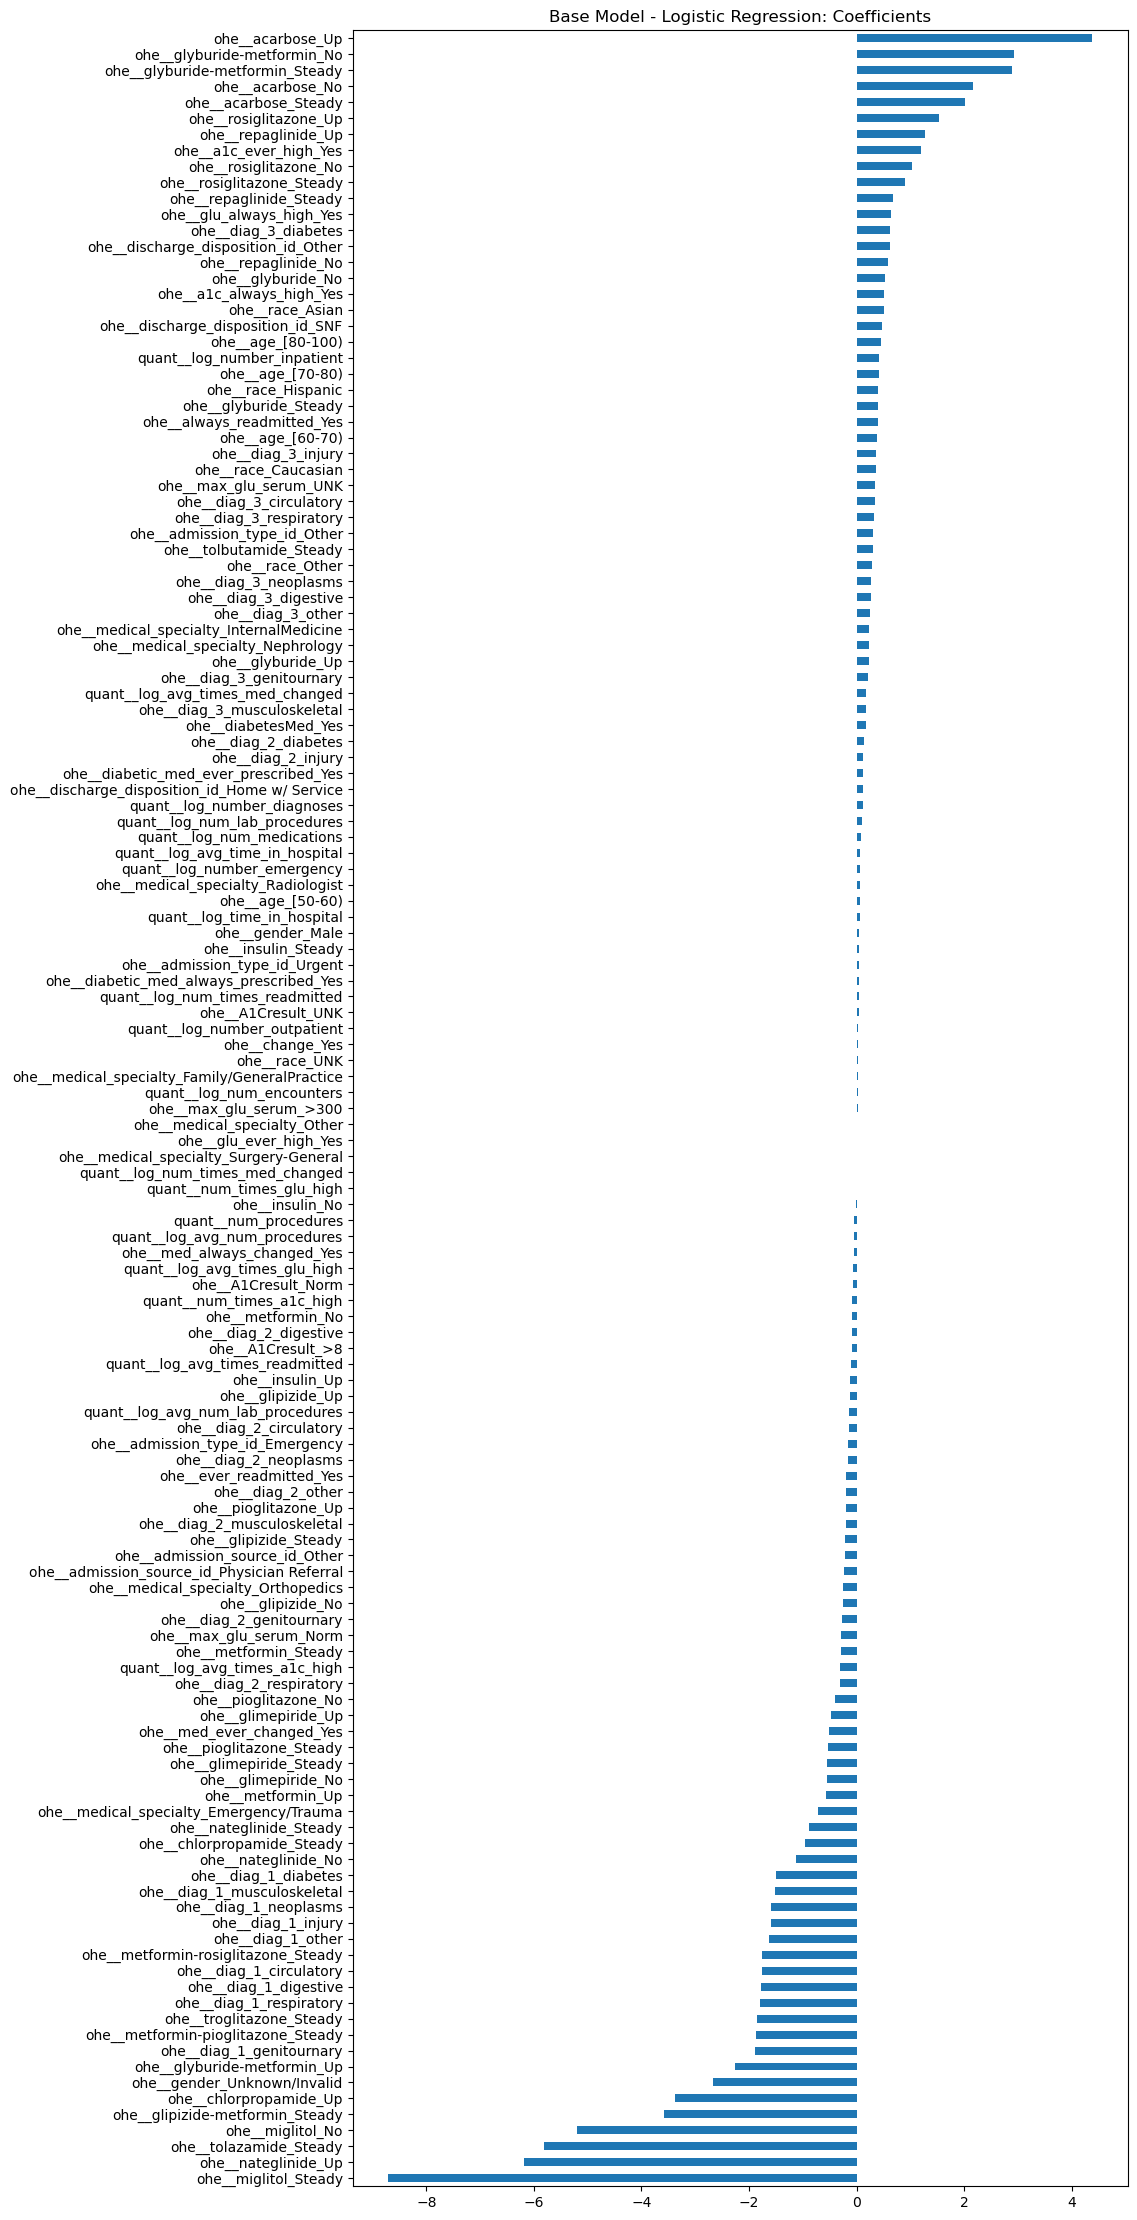

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,28))
coef = pd.Series(base_model.coef_.ravel(), index=base_model.feature_names_in_)
_ = coef.sort_values().plot.barh().set_title('Base Model - Logistic Regression: Coefficients')

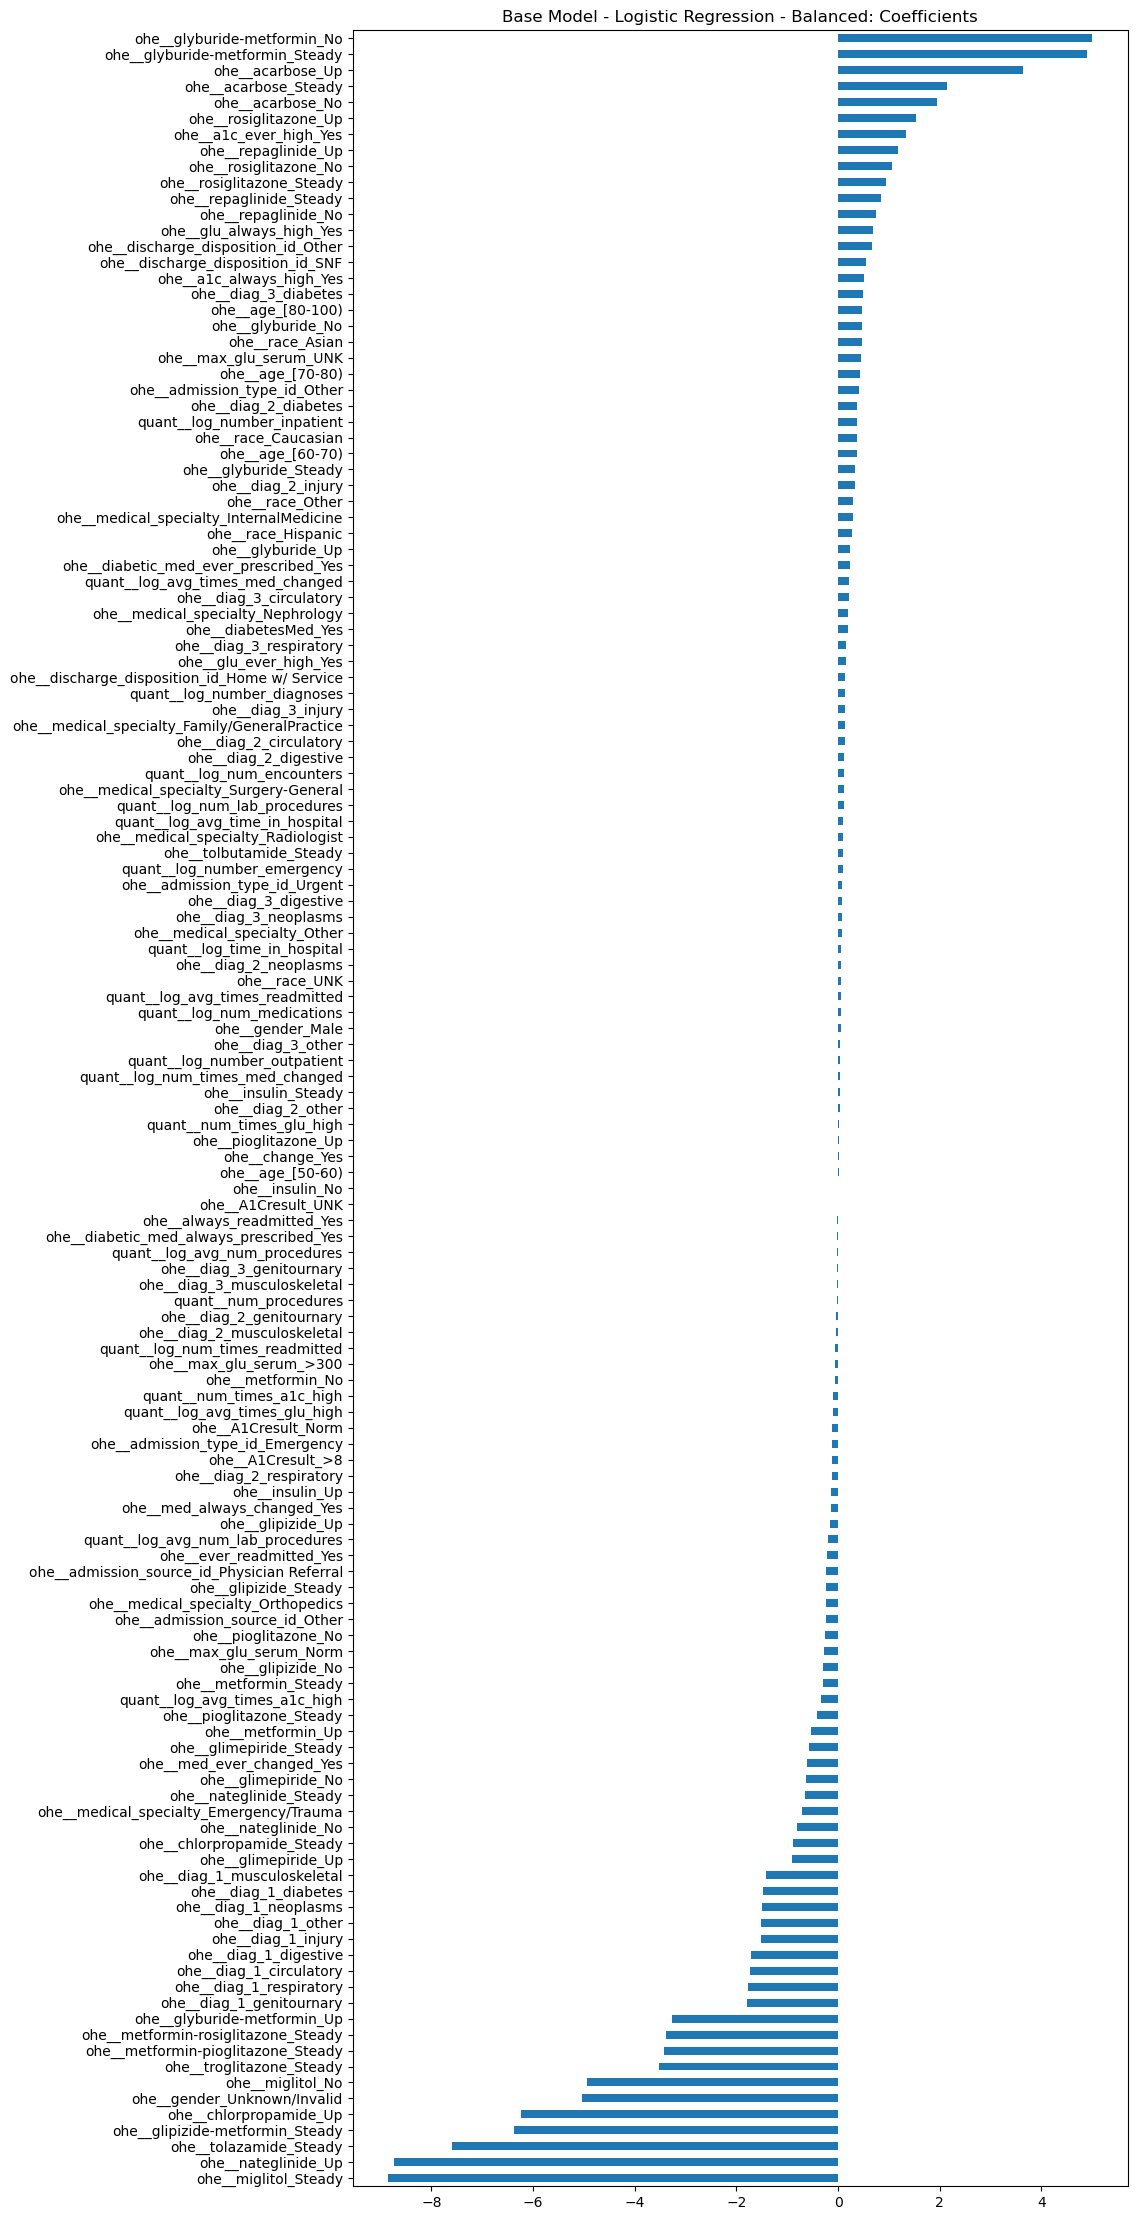

In [17]:
plt.figure(figsize=(10,28))
coef_balanced = pd.Series(base_model_balanced.coef_.ravel(), index=base_model_balanced.feature_names_in_)
_ = coef_balanced.sort_values().plot.barh().set_title('Base Model - Logistic Regression - Balanced: Coefficients')

**Base Model Results Interpretation**

The train and test accuracies are both 95%, same as the accuracy of naive model which always outputs the majority class.

The base model Logistic Regression results in a test AUC of 0.682; the train AUC is higher at 0.717, indicating some overfitting, which regularization may help reduce.

Calibration: As a secondary metric, we are also intrested in whether the actual predicted probabilities output by the model make sense.  Note that the model without any class weights adjustment is reasonably well calibrated on the test set: average readmitted rate is 0.0502 predicted vs. 0.0496 actual. Model with balanced class weights however is (expectedly) not well calibrated: average readmitted rate now jumps up to 0.4368 on test vs. again actual of 0.0496, with only a marginal gain in test AUC: 0.684 (balanced) vs. 0.682 (unbalanced).

Coefficient Interpretation:
Most important variables in Logistic Regression are the ones with the highest absolute value of coefficients.  The top variables are dominated by changes in dosages of various medications such as miglitol (most important), nateglinide, and others.   Primary diagnosis (reflected as diag1) also seems to be an important predictor.  The derived variable (a1c_ever_high) that measures an important blood test result of A1C for diabetic patients is also important.

<a name="4.5.-Candidate-Model-Training"></a>
## 4.5 Candidate Model Training

[Return to top](#Notebook-Contents)

In [2]:
###############################
########## TEST DATA ##########
###############################

from sklearn import datasets

random_state = 109

# create dataset for binary classification with 5 predictors
X, y = datasets.make_classification(
    n_samples=1000,
    n_features=5,
    n_informative=3,
    n_redundant=2,
    random_state=random_state
)

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.8,
    random_state=random_state
)

In [3]:
# Lasso Logistic Regression

# C values to try 
Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

# logistic regression model with L1 penalty and 10-fold CV
lasso = LogisticRegressionCV(
    Cs=Cs, cv=10, penalty='l1', solver='liblinear', n_jobs=-1,
    scoring='roc_auc', max_iter=1000, random_state=109
).fit(X_train, y_train)

# compute classification accuracy for training and test sets
lasso_train_auc_roc = lasso.score(X_train, y_train)
lasso_test_auc_roc = lasso.score(X_test, y_test)

In [4]:
# save metrics for lasso
data = (X_train, X_test, y_train, y_test)
results = [get_performance_metrics(lasso, 'Lasso', data)]
get_results_df(results)

,model,partition,metric,value
0,Lasso,train,AUC-ROC,0.732
1,Lasso,train,AUC-PR,0.723
2,Lasso,train,F1,0.672
3,Lasso,train,recall-sensitivity,0.678
4,Lasso,train,specificity,0.654
5,Lasso,train,precision,0.667
6,Lasso,test,AUC-ROC,0.677
7,Lasso,test,AUC-PR,0.679
8,Lasso,test,F1,0.623
9,Lasso,test,recall-sensitivity,0.639


In [5]:
# Single Decision Tree

# hyperparameter tuning dictionary
params = {'random_state': [109], 
          'criterion': ['gini'], 
          'splitter': ['best'], 
          'max_depth': range(3, 5),
          'min_samples_split': range(2, 30),
          'min_samples_leaf': [1], 
          'min_weight_fraction_leaf': [0.0], 
          'max_features': [None], 
          'max_leaf_nodes': [None], 
          'min_impurity_decrease': [0.0], 
          'class_weight': ['balanced'],
          'ccp_alpha': [0.0]
         }

# 10-fold CV
dt = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    cv=10,
    scoring='roc_auc',
    return_train_score=True
).fit(X_train, y_train)

# refitting outside of GridSearchCV so that we can extract Variable Importances later
dt_tuned = DecisionTreeClassifier(
    max_depth=dt.best_params_['max_depth'],
    min_samples_split=dt.best_params_['min_samples_split'],
    random_state=109
).fit(X_train, y_train)

In [6]:
# save metrics for decision tree
data = (X_train, X_test, y_train, y_test)
results.append(get_performance_metrics(dt_tuned, 'Decision Tree', data))
get_results_df(results).head(10)

,model,partition,metric,value
0,Lasso,train,AUC-ROC,0.732
1,Decision Tree,train,AUC-ROC,0.937
2,Lasso,train,AUC-PR,0.723
3,Decision Tree,train,AUC-PR,0.915
4,Lasso,train,F1,0.672
5,Decision Tree,train,F1,0.882
6,Lasso,train,recall-sensitivity,0.678
7,Decision Tree,train,recall-sensitivity,0.889
8,Lasso,train,specificity,0.654
9,Decision Tree,train,specificity,0.871


In [7]:
# Random Forest

# hyperparameter tuning dictionary
params = {'random_state': [109],
          'n_estimators': [100, 200],
          'criterion': ['gini'],
          'max_depth': [None],
          'min_samples_split': [2,5,10,20],
          'min_samples_leaf': [1],
          'min_weight_fraction_leaf': [0.0],
          'max_features': ['sqrt'],
          'max_leaf_nodes': [None], 
          'min_impurity_decrease': [0.0],
          'bootstrap': [True], 
          'oob_score': [False],
          'n_jobs': [-1],
          'warm_start': [True], 
          'class_weight': ['balanced'],
          'ccp_alpha': [0.0]
         }

# 10-fold CV
rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    cv=10,
    scoring='roc_auc',
    return_train_score=True
).fit(X_train, y_train)

# refitting outside of GridSearchCV so that we can extract Variable Importances later
rf_tuned = RandomForestClassifier(
    max_features=rf.best_params_['max_features'],
    min_samples_split=rf.best_params_['min_samples_split'],
    random_state=109
).fit(X_train, y_train)

In [8]:
# save metrics for random forest
data = (X_train, X_test, y_train, y_test)
results.append(get_performance_metrics(rf_tuned, 'Random Forest', data))
get_results_df(results).head(10)

,model,partition,metric,value
0,Lasso,train,AUC-ROC,0.732
1,Decision Tree,train,AUC-ROC,0.937
2,Random Forest,train,AUC-ROC,1.000
3,Lasso,train,AUC-PR,0.723
4,Decision Tree,train,AUC-PR,0.915
5,Random Forest,train,AUC-PR,1.000
6,Lasso,train,F1,0.672
7,Decision Tree,train,F1,0.882
8,Random Forest,train,F1,0.993
9,Lasso,train,recall-sensitivity,0.678


In [9]:
# Gradient Boosting

# hyperparameter tuning dictionary
params = {'random_state': [109],
          'learning_rate': [0.001,0.01,0.1,1,10,100],
          'n_estimators': [50,100,250,500],
          'min_samples_split': [2], 
          'min_samples_leaf': [1], 
          'min_weight_fraction_leaf': [0.0], 
          'max_depth': [3], 
          'min_impurity_decrease': [0.0], 
          'max_features': [None], 
          'max_leaf_nodes': [None], 
          'warm_start': [True],
          'validation_fraction': [0.1], 
          'n_iter_no_change': [10],
          'ccp_alpha': [0.0]
         }

# 10-fold CV
gb = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=params,
    cv=10,
    scoring='roc_auc',
    return_train_score=True
).fit(X_train, y_train)

# refitting outside of GridSearchCV so that we can extract Variable Importances later
gb_tuned = GradientBoostingClassifier(
    learning_rate=gb.best_params_['learning_rate'],
    n_estimators=gb.best_params_['n_estimators'],
    random_state=109
).fit(X_train, y_train)

In [10]:
# save metrics for gradient boosting
data = (X_train, X_test, y_train, y_test)
results.append(get_performance_metrics(gb_tuned, 'Gradient Boosting', data))
get_results_df(results).head(10)

,model,partition,metric,value
0,Lasso,train,AUC-ROC,0.732
1,Decision Tree,train,AUC-ROC,0.937
2,Random Forest,train,AUC-ROC,1.000
3,Gradient Boosting,train,AUC-ROC,0.996
4,Lasso,train,AUC-PR,0.723
5,Decision Tree,train,AUC-PR,0.915
6,Random Forest,train,AUC-PR,1.000
7,Gradient Boosting,train,AUC-PR,0.997
8,Lasso,train,F1,0.672
9,Decision Tree,train,F1,0.882


<a name="5.-Model-Selection-and-Evaluation"></a>
# 5. Model Selection and Evaluation

[Return to top](#Notebook-Contents)

<a name="5.1.-Model-Selection"></a>
## 5.1 Model Selection

[Return to top](#Notebook-Contents)

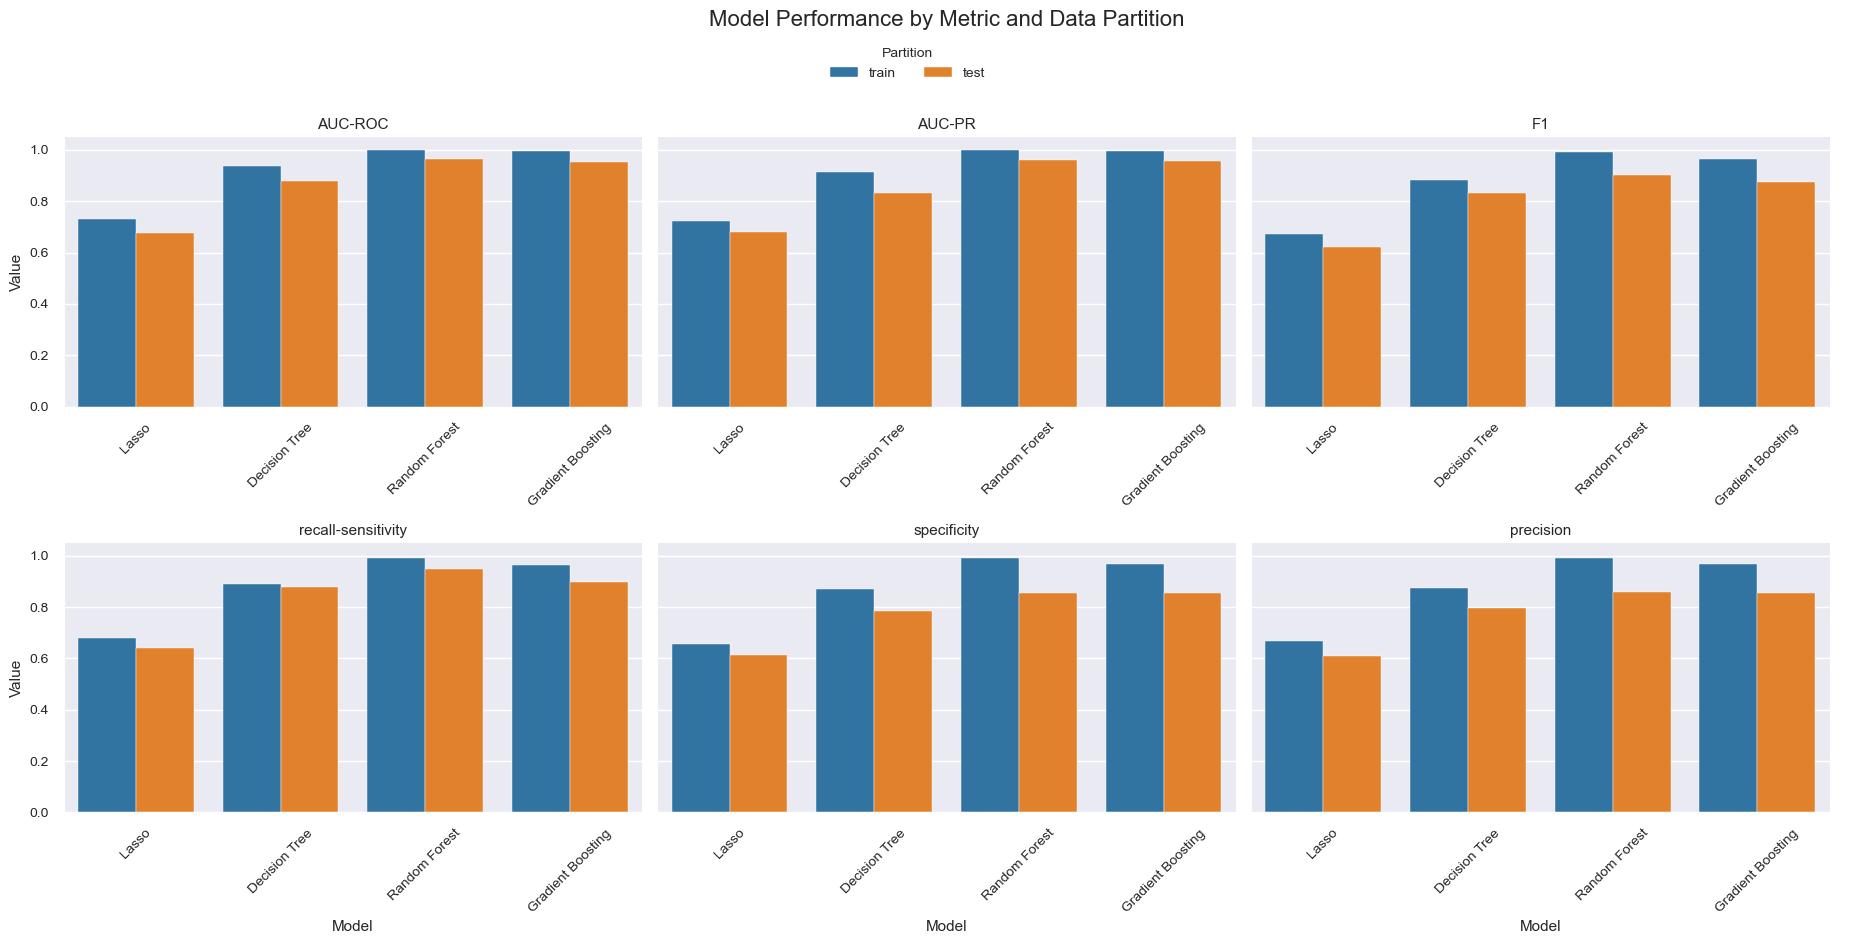

In [11]:
results_df = get_results_df(results)
plot_performance_metrics(results_df)

In [12]:
# dict of model names and classifiers for plotting curves
models = {
    "Lasso": lasso,
    "Decision Tree": dt,
    "Random Forest": rf,
    "Gradient Boosting": gb
}

# data
data = (X_train, X_test, y_train, y_test)

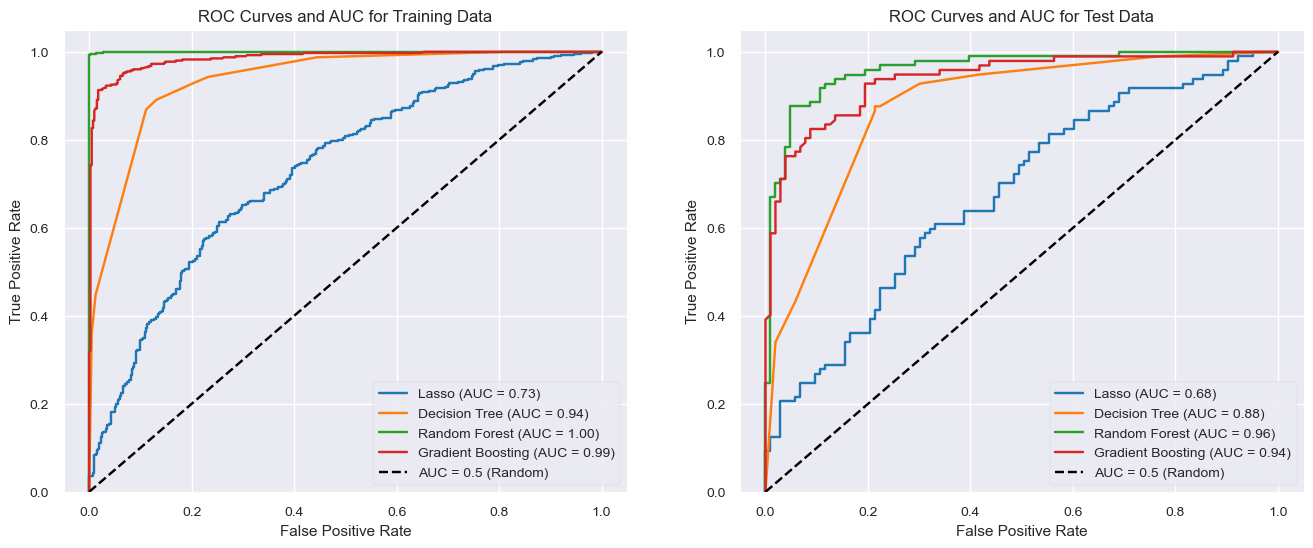

In [13]:
# ROC Curve
plot_ROC_curves(models, data)

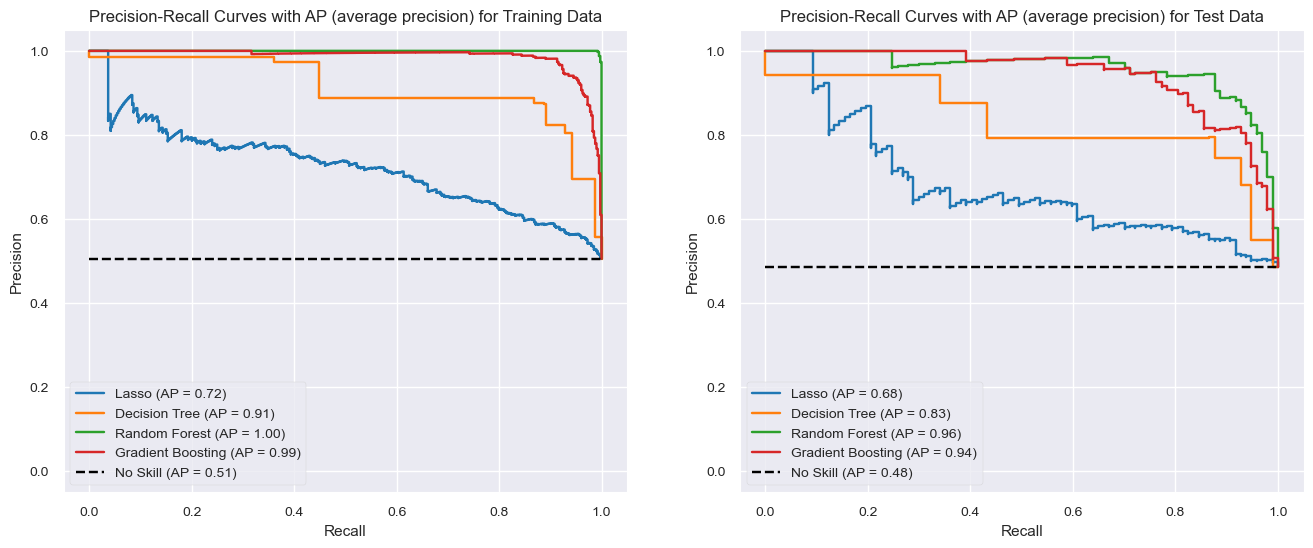

In [14]:
# Precision Recall Curve
plot_PR_curves(models, data)

<a name="5.3.-Variable-Importance"></a>
## 5.3 Variable Importance

[Return to top](#Notebook-Contents)

<a name="6.-Conclusions"></a>
# 6. Conclusions

[Return to top](#Notebook-Contents)

We found this project to be both interesting and quite challenging. Blah blah blah.

Perhaps the three most perplexing issues we encountered were:

1. placeholder1 

2. placeholder2

3. placeholder3

<a name="6.1.-Patient-Early-Readmittance-Rate"></a>
## 6.1 Patient Early Readmittance Rate

[Return to top](#Notebook-Contents)

<a name="6.2.-Patient-Risk-Profiles"></a>
## 6.2 Patient Risk Profiles

[Return to top](#Notebook-Contents)

<a name="7.-Future-Work"></a>
# 7. Future Work

[Return to top](#Notebook-Contents)

In our analysis of the Chest X-ray dataset we have tried a variety of modeling and feature engineering approaches, but there are still several additional steps that could be taken:

1. placeholder1

2. placeholder2

3. placeholder2

<a name="8.-References"></a>
# 8. References

[Return to top](#Notebook-Contents)

**The following are links to papers, blogs, and tutorials we found useful during the development of this project:**

Fine-tuning for transfer learning models:
https://keras.io/guides/transfer_learning/

Medical neural networks:
https://glassboxmedicine.com/

Image classification using CNNs:
https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a

Comparison of ResNet50 and VGG19 and training from stratch for X-ray images dataset:
https://www.sciencedirect.com/science/article/pii/S2666285X21000558

Tensorflow Applications for base model:
https://keras.io/api/applications/

Tensorboard confusion matrix:
https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12

Pre-processing and modeling pipelines (ResNet50):
https://towardsdatascience.com/time-to-choose-tensorflow-data-over-imagedatagenerator-215e594f2435

Image data input pipelines:
https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5

Split TF datasets:
https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438

Transfer learning with EfficientNet:
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

Training greyscale images using transfer learning:
https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images

Multi-label vs multi-class classification:
https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/

Multi-label classification example use-case:
https://towardsdatascience.com/fast-ai-season-1-episode-3-a-case-of-multi-label-classification-a4a90672a889

Element-wise sigmoid:
https://www.programcreek.com/python/example/93769/keras.backend.sigmoid

Element-wise sigmoid:
https://stackoverflow.com/questions/52090857/how-to-apply-sigmoid-function-for-each-outputs-in-keras

DenseNet121:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8189817/